# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [1]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [2]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=350  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=512, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=256, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=256, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

In [3]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


     


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    # cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    # cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), (1024,1)]
    #cfg = [48, (96,2), 96, (192,2), 192, (384,2), 384, 384, 384, 384, 384, (768,2), (1024,1)]
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512,1024,1024]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        #print("X",out.shape)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=100, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [5]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 5*show_step == 0:
#             if batch_idx % 2*show_step == 0:
#                 print(model.layers[1].conv1D.weight.shape)
#                 print(model.layers[1].conv1D.weight[0:2][0:2])
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
            f1=open("Cifar10_INFO.txt","a+")
            f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
            f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [6]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
    f1=open("Cifar10_INFO.txt","a+")
    f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [7]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
    f1=open("Cifar10_INFO.txt","a+")
    f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    f1.close()

In [8]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [9]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
    if epoch>=80 and (epoch-80)%10==0:
        test(epoch)
    
# writer = SummaryWriter() 
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.313687, Accuracy: 7.62
Train Epoch: 0 [2560/50000 (6%)]	Loss: 2.273314, Accuracy: 13.48
Train Epoch: 0 [5120/50000 (11%)]	Loss: 2.047954, Accuracy: 20.90
Train Epoch: 0 [7680/50000 (17%)]	Loss: 2.038328, Accuracy: 21.29
Train Epoch: 0 [10240/50000 (23%)]	Loss: 1.954112, Accuracy: 26.76
Train Epoch: 0 [12800/50000 (28%)]	Loss: 1.849241, Accuracy: 29.69
Train Epoch: 0 [15360/50000 (34%)]	Loss: 1.838697, Accuracy: 28.91
Train Epoch: 0 [17920/50000 (40%)]	Loss: 1.747862, Accuracy: 32.81
Train Epoch: 0 [20480/50000 (45%)]	Loss: 1.732506, Accuracy: 37.11
Train Epoch: 0 [23040/50000 (51%)]	Loss: 1.734231, Accuracy: 36.13
Train Epoch: 0 [25600/50000 (57%)]	Loss: 1.739201, Accuracy: 35.94
Train Epoch: 0 [28160/50000 (62%)]	Loss: 1.685335, Accuracy: 36.13
Train Epoch: 0 [30720/50000 (68%)]	Loss: 1.675387, Accuracy: 34.96
Train Epoch: 0 [33280/50000 (74%)]	Loss: 1.696462, Accuracy: 37.89
Train Epoch: 0 [35840/50000 (80%)]	Loss: 1.608788, Accuracy: 39.45
Train

Train Epoch: 6 [12800/50000 (28%)]	Loss: 0.716494, Accuracy: 74.41
Train Epoch: 6 [15360/50000 (34%)]	Loss: 0.809948, Accuracy: 72.66
Train Epoch: 6 [17920/50000 (40%)]	Loss: 0.682101, Accuracy: 75.20
Train Epoch: 6 [20480/50000 (45%)]	Loss: 0.882956, Accuracy: 68.16
Train Epoch: 6 [23040/50000 (51%)]	Loss: 0.736132, Accuracy: 75.00
Train Epoch: 6 [25600/50000 (57%)]	Loss: 0.756905, Accuracy: 73.24
Train Epoch: 6 [28160/50000 (62%)]	Loss: 0.782910, Accuracy: 70.51
Train Epoch: 6 [30720/50000 (68%)]	Loss: 0.717458, Accuracy: 75.20
Train Epoch: 6 [33280/50000 (74%)]	Loss: 0.702645, Accuracy: 73.63
Train Epoch: 6 [35840/50000 (80%)]	Loss: 0.728279, Accuracy: 75.59
Train Epoch: 6 [38400/50000 (85%)]	Loss: 0.670053, Accuracy: 75.78
Train Epoch: 6 [40960/50000 (91%)]	Loss: 0.776227, Accuracy: 71.48
Train Epoch: 6 [43520/50000 (97%)]	Loss: 0.731439, Accuracy: 71.29

Validation set: Average loss: 0.8305, Accuracy: 3535/5000 (70.00%)

the time of this epoch:[19.63342523574829 s]
Train Epoch: 7 

Train Epoch: 12 [25600/50000 (57%)]	Loss: 0.575274, Accuracy: 81.84
Train Epoch: 12 [28160/50000 (62%)]	Loss: 0.519635, Accuracy: 82.81
Train Epoch: 12 [30720/50000 (68%)]	Loss: 0.610574, Accuracy: 79.69
Train Epoch: 12 [33280/50000 (74%)]	Loss: 0.541866, Accuracy: 79.88
Train Epoch: 12 [35840/50000 (80%)]	Loss: 0.610694, Accuracy: 81.05
Train Epoch: 12 [38400/50000 (85%)]	Loss: 0.592537, Accuracy: 79.49
Train Epoch: 12 [40960/50000 (91%)]	Loss: 0.492298, Accuracy: 83.01
Train Epoch: 12 [43520/50000 (97%)]	Loss: 0.464964, Accuracy: 82.62

Validation set: Average loss: 0.6593, Accuracy: 3890/5000 (77.00%)

the time of this epoch:[19.545862197875977 s]
Train Epoch: 13 [0/50000 (0%)]	Loss: 0.492670, Accuracy: 81.64
Train Epoch: 13 [2560/50000 (6%)]	Loss: 0.393364, Accuracy: 87.50
Train Epoch: 13 [5120/50000 (11%)]	Loss: 0.468518, Accuracy: 85.74
Train Epoch: 13 [7680/50000 (17%)]	Loss: 0.457198, Accuracy: 85.55
Train Epoch: 13 [10240/50000 (23%)]	Loss: 0.417025, Accuracy: 85.94
Train Epoc

Train Epoch: 18 [35840/50000 (80%)]	Loss: 0.381858, Accuracy: 87.89
Train Epoch: 18 [38400/50000 (85%)]	Loss: 0.464563, Accuracy: 86.13
Train Epoch: 18 [40960/50000 (91%)]	Loss: 0.426999, Accuracy: 85.55
Train Epoch: 18 [43520/50000 (97%)]	Loss: 0.456663, Accuracy: 83.98

Validation set: Average loss: 0.6819, Accuracy: 3845/5000 (76.00%)

the time of this epoch:[19.525726556777954 s]
Train Epoch: 19 [0/50000 (0%)]	Loss: 0.403051, Accuracy: 86.13
Train Epoch: 19 [2560/50000 (6%)]	Loss: 0.376724, Accuracy: 86.91
Train Epoch: 19 [5120/50000 (11%)]	Loss: 0.418500, Accuracy: 85.16
Train Epoch: 19 [7680/50000 (17%)]	Loss: 0.337129, Accuracy: 86.72
Train Epoch: 19 [10240/50000 (23%)]	Loss: 0.370283, Accuracy: 85.94
Train Epoch: 19 [12800/50000 (28%)]	Loss: 0.421426, Accuracy: 84.57
Train Epoch: 19 [15360/50000 (34%)]	Loss: 0.410980, Accuracy: 85.35
Train Epoch: 19 [17920/50000 (40%)]	Loss: 0.381924, Accuracy: 86.33
Train Epoch: 19 [20480/50000 (45%)]	Loss: 0.403642, Accuracy: 85.74
Train Epoc


Validation set: Average loss: 0.4935, Accuracy: 4157/5000 (83.00%)

the time of this epoch:[19.522761344909668 s]
Train Epoch: 25 [0/50000 (0%)]	Loss: 0.340789, Accuracy: 88.67
Train Epoch: 25 [2560/50000 (6%)]	Loss: 0.329062, Accuracy: 88.48
Train Epoch: 25 [5120/50000 (11%)]	Loss: 0.375051, Accuracy: 86.13
Train Epoch: 25 [7680/50000 (17%)]	Loss: 0.296563, Accuracy: 89.65
Train Epoch: 25 [10240/50000 (23%)]	Loss: 0.373179, Accuracy: 87.50
Train Epoch: 25 [12800/50000 (28%)]	Loss: 0.411021, Accuracy: 87.11
Train Epoch: 25 [15360/50000 (34%)]	Loss: 0.383127, Accuracy: 87.30
Train Epoch: 25 [17920/50000 (40%)]	Loss: 0.402698, Accuracy: 86.52
Train Epoch: 25 [20480/50000 (45%)]	Loss: 0.373706, Accuracy: 87.50
Train Epoch: 25 [23040/50000 (51%)]	Loss: 0.384738, Accuracy: 86.52
Train Epoch: 25 [25600/50000 (57%)]	Loss: 0.365218, Accuracy: 85.74
Train Epoch: 25 [28160/50000 (62%)]	Loss: 0.407415, Accuracy: 86.91
Train Epoch: 25 [30720/50000 (68%)]	Loss: 0.351858, Accuracy: 88.87
Train Epoc

Train Epoch: 31 [5120/50000 (11%)]	Loss: 0.290589, Accuracy: 89.65
Train Epoch: 31 [7680/50000 (17%)]	Loss: 0.309385, Accuracy: 88.48
Train Epoch: 31 [10240/50000 (23%)]	Loss: 0.338454, Accuracy: 88.48
Train Epoch: 31 [12800/50000 (28%)]	Loss: 0.305629, Accuracy: 88.87
Train Epoch: 31 [15360/50000 (34%)]	Loss: 0.312655, Accuracy: 90.04
Train Epoch: 31 [17920/50000 (40%)]	Loss: 0.302240, Accuracy: 89.26
Train Epoch: 31 [20480/50000 (45%)]	Loss: 0.340371, Accuracy: 88.48
Train Epoch: 31 [23040/50000 (51%)]	Loss: 0.383769, Accuracy: 85.35
Train Epoch: 31 [25600/50000 (57%)]	Loss: 0.316426, Accuracy: 88.48
Train Epoch: 31 [28160/50000 (62%)]	Loss: 0.403340, Accuracy: 86.91
Train Epoch: 31 [30720/50000 (68%)]	Loss: 0.340723, Accuracy: 89.06
Train Epoch: 31 [33280/50000 (74%)]	Loss: 0.305136, Accuracy: 90.23
Train Epoch: 31 [35840/50000 (80%)]	Loss: 0.423843, Accuracy: 85.16
Train Epoch: 31 [38400/50000 (85%)]	Loss: 0.308085, Accuracy: 90.04
Train Epoch: 31 [40960/50000 (91%)]	Loss: 0.351624

Train Epoch: 37 [15360/50000 (34%)]	Loss: 0.281405, Accuracy: 89.65
Train Epoch: 37 [17920/50000 (40%)]	Loss: 0.312738, Accuracy: 87.50
Train Epoch: 37 [20480/50000 (45%)]	Loss: 0.326438, Accuracy: 89.45
Train Epoch: 37 [23040/50000 (51%)]	Loss: 0.360535, Accuracy: 87.89
Train Epoch: 37 [25600/50000 (57%)]	Loss: 0.394497, Accuracy: 86.91
Train Epoch: 37 [28160/50000 (62%)]	Loss: 0.362327, Accuracy: 87.30
Train Epoch: 37 [30720/50000 (68%)]	Loss: 0.330938, Accuracy: 89.84
Train Epoch: 37 [33280/50000 (74%)]	Loss: 0.313084, Accuracy: 90.23
Train Epoch: 37 [35840/50000 (80%)]	Loss: 0.381437, Accuracy: 88.48
Train Epoch: 37 [38400/50000 (85%)]	Loss: 0.298597, Accuracy: 90.04
Train Epoch: 37 [40960/50000 (91%)]	Loss: 0.407477, Accuracy: 87.30
Train Epoch: 37 [43520/50000 (97%)]	Loss: 0.333371, Accuracy: 89.65

Validation set: Average loss: 0.5786, Accuracy: 4068/5000 (81.00%)

the time of this epoch:[19.533770322799683 s]
Train Epoch: 38 [0/50000 (0%)]	Loss: 0.348509, Accuracy: 87.89
Train 

Train Epoch: 43 [25600/50000 (57%)]	Loss: 0.305298, Accuracy: 88.48
Train Epoch: 43 [28160/50000 (62%)]	Loss: 0.360332, Accuracy: 88.67
Train Epoch: 43 [30720/50000 (68%)]	Loss: 0.418336, Accuracy: 85.94
Train Epoch: 43 [33280/50000 (74%)]	Loss: 0.320397, Accuracy: 89.45
Train Epoch: 43 [35840/50000 (80%)]	Loss: 0.255282, Accuracy: 91.41
Train Epoch: 43 [38400/50000 (85%)]	Loss: 0.347851, Accuracy: 88.09
Train Epoch: 43 [40960/50000 (91%)]	Loss: 0.334966, Accuracy: 87.89
Train Epoch: 43 [43520/50000 (97%)]	Loss: 0.329811, Accuracy: 88.87

Validation set: Average loss: 0.5101, Accuracy: 4179/5000 (83.00%)

the time of this epoch:[19.51059079170227 s]
Train Epoch: 44 [0/50000 (0%)]	Loss: 0.307029, Accuracy: 88.48
Train Epoch: 44 [2560/50000 (6%)]	Loss: 0.203666, Accuracy: 93.36
Train Epoch: 44 [5120/50000 (11%)]	Loss: 0.317640, Accuracy: 88.87
Train Epoch: 44 [7680/50000 (17%)]	Loss: 0.319477, Accuracy: 88.09
Train Epoch: 44 [10240/50000 (23%)]	Loss: 0.306318, Accuracy: 91.60
Train Epoch

Train Epoch: 49 [35840/50000 (80%)]	Loss: 0.319115, Accuracy: 90.82
Train Epoch: 49 [38400/50000 (85%)]	Loss: 0.328547, Accuracy: 87.70
Train Epoch: 49 [40960/50000 (91%)]	Loss: 0.355646, Accuracy: 88.67
Train Epoch: 49 [43520/50000 (97%)]	Loss: 0.357366, Accuracy: 87.50

Validation set: Average loss: 0.6532, Accuracy: 3948/5000 (78.00%)

the time of this epoch:[19.50809383392334 s]
Train Epoch: 50 [0/50000 (0%)]	Loss: 0.286142, Accuracy: 90.62
Train Epoch: 50 [2560/50000 (6%)]	Loss: 0.279027, Accuracy: 90.43
Train Epoch: 50 [5120/50000 (11%)]	Loss: 0.218607, Accuracy: 91.60
Train Epoch: 50 [7680/50000 (17%)]	Loss: 0.283970, Accuracy: 89.84
Train Epoch: 50 [10240/50000 (23%)]	Loss: 0.318259, Accuracy: 88.67
Train Epoch: 50 [12800/50000 (28%)]	Loss: 0.282367, Accuracy: 90.23
Train Epoch: 50 [15360/50000 (34%)]	Loss: 0.279349, Accuracy: 90.04
Train Epoch: 50 [17920/50000 (40%)]	Loss: 0.329195, Accuracy: 89.45
Train Epoch: 50 [20480/50000 (45%)]	Loss: 0.271044, Accuracy: 89.45
Train Epoch


Validation set: Average loss: 0.6973, Accuracy: 3882/5000 (77.00%)

the time of this epoch:[19.505674362182617 s]
Train Epoch: 56 [0/50000 (0%)]	Loss: 0.267895, Accuracy: 91.21
Train Epoch: 56 [2560/50000 (6%)]	Loss: 0.257039, Accuracy: 91.99
Train Epoch: 56 [5120/50000 (11%)]	Loss: 0.243798, Accuracy: 91.60
Train Epoch: 56 [7680/50000 (17%)]	Loss: 0.279314, Accuracy: 90.82
Train Epoch: 56 [10240/50000 (23%)]	Loss: 0.230159, Accuracy: 92.77
Train Epoch: 56 [12800/50000 (28%)]	Loss: 0.259449, Accuracy: 91.21
Train Epoch: 56 [15360/50000 (34%)]	Loss: 0.237057, Accuracy: 91.99
Train Epoch: 56 [17920/50000 (40%)]	Loss: 0.265577, Accuracy: 91.02
Train Epoch: 56 [20480/50000 (45%)]	Loss: 0.272362, Accuracy: 90.43
Train Epoch: 56 [23040/50000 (51%)]	Loss: 0.269868, Accuracy: 91.02
Train Epoch: 56 [25600/50000 (57%)]	Loss: 0.317470, Accuracy: 88.48
Train Epoch: 56 [28160/50000 (62%)]	Loss: 0.312940, Accuracy: 89.06
Train Epoch: 56 [30720/50000 (68%)]	Loss: 0.302112, Accuracy: 89.65
Train Epoc

Train Epoch: 62 [5120/50000 (11%)]	Loss: 0.280880, Accuracy: 90.23
Train Epoch: 62 [7680/50000 (17%)]	Loss: 0.272034, Accuracy: 90.43
Train Epoch: 62 [10240/50000 (23%)]	Loss: 0.287102, Accuracy: 90.43
Train Epoch: 62 [12800/50000 (28%)]	Loss: 0.251306, Accuracy: 91.21
Train Epoch: 62 [15360/50000 (34%)]	Loss: 0.261761, Accuracy: 90.82
Train Epoch: 62 [17920/50000 (40%)]	Loss: 0.247650, Accuracy: 90.82
Train Epoch: 62 [20480/50000 (45%)]	Loss: 0.342565, Accuracy: 89.26
Train Epoch: 62 [23040/50000 (51%)]	Loss: 0.192813, Accuracy: 93.55
Train Epoch: 62 [25600/50000 (57%)]	Loss: 0.275537, Accuracy: 91.41
Train Epoch: 62 [28160/50000 (62%)]	Loss: 0.301555, Accuracy: 88.09
Train Epoch: 62 [30720/50000 (68%)]	Loss: 0.240578, Accuracy: 90.62
Train Epoch: 62 [33280/50000 (74%)]	Loss: 0.255790, Accuracy: 91.80
Train Epoch: 62 [35840/50000 (80%)]	Loss: 0.309131, Accuracy: 88.67
Train Epoch: 62 [38400/50000 (85%)]	Loss: 0.312391, Accuracy: 89.45
Train Epoch: 62 [40960/50000 (91%)]	Loss: 0.225859

Train Epoch: 68 [15360/50000 (34%)]	Loss: 0.230943, Accuracy: 91.99
Train Epoch: 68 [17920/50000 (40%)]	Loss: 0.224567, Accuracy: 91.80
Train Epoch: 68 [20480/50000 (45%)]	Loss: 0.293569, Accuracy: 90.43
Train Epoch: 68 [23040/50000 (51%)]	Loss: 0.286178, Accuracy: 89.84
Train Epoch: 68 [25600/50000 (57%)]	Loss: 0.291913, Accuracy: 90.04
Train Epoch: 68 [28160/50000 (62%)]	Loss: 0.286592, Accuracy: 90.82
Train Epoch: 68 [30720/50000 (68%)]	Loss: 0.332903, Accuracy: 89.06
Train Epoch: 68 [33280/50000 (74%)]	Loss: 0.284392, Accuracy: 91.02
Train Epoch: 68 [35840/50000 (80%)]	Loss: 0.268047, Accuracy: 91.80
Train Epoch: 68 [38400/50000 (85%)]	Loss: 0.220265, Accuracy: 92.58
Train Epoch: 68 [40960/50000 (91%)]	Loss: 0.305121, Accuracy: 90.04
Train Epoch: 68 [43520/50000 (97%)]	Loss: 0.282790, Accuracy: 90.23

Validation set: Average loss: 0.5756, Accuracy: 4145/5000 (82.00%)

the time of this epoch:[19.43285346031189 s]
Train Epoch: 69 [0/50000 (0%)]	Loss: 0.264899, Accuracy: 90.04
Train E

Train Epoch: 74 [25600/50000 (57%)]	Loss: 0.284256, Accuracy: 89.26
Train Epoch: 74 [28160/50000 (62%)]	Loss: 0.292825, Accuracy: 89.65
Train Epoch: 74 [30720/50000 (68%)]	Loss: 0.289261, Accuracy: 89.65
Train Epoch: 74 [33280/50000 (74%)]	Loss: 0.282061, Accuracy: 91.02
Train Epoch: 74 [35840/50000 (80%)]	Loss: 0.325780, Accuracy: 89.06
Train Epoch: 74 [38400/50000 (85%)]	Loss: 0.306352, Accuracy: 87.50
Train Epoch: 74 [40960/50000 (91%)]	Loss: 0.285857, Accuracy: 89.26
Train Epoch: 74 [43520/50000 (97%)]	Loss: 0.245092, Accuracy: 90.62

Validation set: Average loss: 0.4718, Accuracy: 4205/5000 (84.00%)

the time of this epoch:[19.4916832447052 s]
Train Epoch: 75 [0/50000 (0%)]	Loss: 0.234558, Accuracy: 92.38
Train Epoch: 75 [2560/50000 (6%)]	Loss: 0.233409, Accuracy: 91.41
Train Epoch: 75 [5120/50000 (11%)]	Loss: 0.204667, Accuracy: 94.34
Train Epoch: 75 [7680/50000 (17%)]	Loss: 0.164990, Accuracy: 94.14
Train Epoch: 75 [10240/50000 (23%)]	Loss: 0.328800, Accuracy: 88.09
Train Epoch:

Train Epoch: 80 [35840/50000 (80%)]	Loss: 0.281764, Accuracy: 89.26
Train Epoch: 80 [38400/50000 (85%)]	Loss: 0.246641, Accuracy: 91.60
Train Epoch: 80 [40960/50000 (91%)]	Loss: 0.255734, Accuracy: 91.80
Train Epoch: 80 [43520/50000 (97%)]	Loss: 0.260131, Accuracy: 91.80

Validation set: Average loss: 0.5070, Accuracy: 4190/5000 (83.00%)

the time of this epoch:[19.46075201034546 s]
Train Epoch: 81 [0/50000 (0%)]	Loss: 0.275904, Accuracy: 90.23
Train Epoch: 81 [2560/50000 (6%)]	Loss: 0.249765, Accuracy: 90.23
Train Epoch: 81 [5120/50000 (11%)]	Loss: 0.218995, Accuracy: 92.19
Train Epoch: 81 [7680/50000 (17%)]	Loss: 0.267344, Accuracy: 90.62
Train Epoch: 81 [10240/50000 (23%)]	Loss: 0.281373, Accuracy: 90.62
Train Epoch: 81 [12800/50000 (28%)]	Loss: 0.264004, Accuracy: 90.43
Train Epoch: 81 [15360/50000 (34%)]	Loss: 0.269897, Accuracy: 90.82
Train Epoch: 81 [17920/50000 (40%)]	Loss: 0.245045, Accuracy: 91.02
Train Epoch: 81 [20480/50000 (45%)]	Loss: 0.304905, Accuracy: 88.67
Train Epoch


Validation set: Average loss: 0.5030, Accuracy: 4204/5000 (84.00%)

the time of this epoch:[19.43479609489441 s]
Train Epoch: 87 [0/50000 (0%)]	Loss: 0.217384, Accuracy: 93.16
Train Epoch: 87 [2560/50000 (6%)]	Loss: 0.261375, Accuracy: 92.38
Train Epoch: 87 [5120/50000 (11%)]	Loss: 0.184298, Accuracy: 93.55
Train Epoch: 87 [7680/50000 (17%)]	Loss: 0.207138, Accuracy: 92.77
Train Epoch: 87 [10240/50000 (23%)]	Loss: 0.215939, Accuracy: 92.38
Train Epoch: 87 [12800/50000 (28%)]	Loss: 0.261689, Accuracy: 89.65
Train Epoch: 87 [15360/50000 (34%)]	Loss: 0.227677, Accuracy: 91.99
Train Epoch: 87 [17920/50000 (40%)]	Loss: 0.253341, Accuracy: 90.43
Train Epoch: 87 [20480/50000 (45%)]	Loss: 0.238749, Accuracy: 91.21
Train Epoch: 87 [23040/50000 (51%)]	Loss: 0.267006, Accuracy: 90.23
Train Epoch: 87 [25600/50000 (57%)]	Loss: 0.279527, Accuracy: 90.43
Train Epoch: 87 [28160/50000 (62%)]	Loss: 0.306600, Accuracy: 88.28
Train Epoch: 87 [30720/50000 (68%)]	Loss: 0.250775, Accuracy: 90.43
Train Epoch

Train Epoch: 93 [5120/50000 (11%)]	Loss: 0.194681, Accuracy: 93.36
Train Epoch: 93 [7680/50000 (17%)]	Loss: 0.233238, Accuracy: 91.80
Train Epoch: 93 [10240/50000 (23%)]	Loss: 0.205767, Accuracy: 92.77
Train Epoch: 93 [12800/50000 (28%)]	Loss: 0.250132, Accuracy: 92.19
Train Epoch: 93 [15360/50000 (34%)]	Loss: 0.227931, Accuracy: 92.38
Train Epoch: 93 [17920/50000 (40%)]	Loss: 0.212107, Accuracy: 92.58
Train Epoch: 93 [20480/50000 (45%)]	Loss: 0.258440, Accuracy: 90.82
Train Epoch: 93 [23040/50000 (51%)]	Loss: 0.311039, Accuracy: 89.06
Train Epoch: 93 [25600/50000 (57%)]	Loss: 0.297497, Accuracy: 90.62
Train Epoch: 93 [28160/50000 (62%)]	Loss: 0.228983, Accuracy: 91.21
Train Epoch: 93 [30720/50000 (68%)]	Loss: 0.269383, Accuracy: 91.02
Train Epoch: 93 [33280/50000 (74%)]	Loss: 0.200634, Accuracy: 92.19
Train Epoch: 93 [35840/50000 (80%)]	Loss: 0.304272, Accuracy: 90.23
Train Epoch: 93 [38400/50000 (85%)]	Loss: 0.294874, Accuracy: 91.41
Train Epoch: 93 [40960/50000 (91%)]	Loss: 0.239686

Train Epoch: 99 [15360/50000 (34%)]	Loss: 0.183559, Accuracy: 94.34
Train Epoch: 99 [17920/50000 (40%)]	Loss: 0.265437, Accuracy: 90.23
Train Epoch: 99 [20480/50000 (45%)]	Loss: 0.266395, Accuracy: 90.04
Train Epoch: 99 [23040/50000 (51%)]	Loss: 0.261562, Accuracy: 91.60
Train Epoch: 99 [25600/50000 (57%)]	Loss: 0.234535, Accuracy: 91.60
Train Epoch: 99 [28160/50000 (62%)]	Loss: 0.210772, Accuracy: 92.38
Train Epoch: 99 [30720/50000 (68%)]	Loss: 0.229195, Accuracy: 91.99
Train Epoch: 99 [33280/50000 (74%)]	Loss: 0.278996, Accuracy: 90.04
Train Epoch: 99 [35840/50000 (80%)]	Loss: 0.302580, Accuracy: 89.65
Train Epoch: 99 [38400/50000 (85%)]	Loss: 0.321770, Accuracy: 90.43
Train Epoch: 99 [40960/50000 (91%)]	Loss: 0.271768, Accuracy: 89.84
Train Epoch: 99 [43520/50000 (97%)]	Loss: 0.335518, Accuracy: 89.06

Validation set: Average loss: 0.6552, Accuracy: 3954/5000 (79.00%)

the time of this epoch:[19.45371103286743 s]
Train Epoch: 100 [0/50000 (0%)]	Loss: 0.221760, Accuracy: 92.77
Train 

Train Epoch: 105 [20480/50000 (45%)]	Loss: 0.120765, Accuracy: 95.12
Train Epoch: 105 [23040/50000 (51%)]	Loss: 0.065454, Accuracy: 97.66
Train Epoch: 105 [25600/50000 (57%)]	Loss: 0.102562, Accuracy: 96.29
Train Epoch: 105 [28160/50000 (62%)]	Loss: 0.063228, Accuracy: 98.24
Train Epoch: 105 [30720/50000 (68%)]	Loss: 0.069486, Accuracy: 98.05
Train Epoch: 105 [33280/50000 (74%)]	Loss: 0.061063, Accuracy: 98.63
Train Epoch: 105 [35840/50000 (80%)]	Loss: 0.100697, Accuracy: 96.29
Train Epoch: 105 [38400/50000 (85%)]	Loss: 0.082416, Accuracy: 96.68
Train Epoch: 105 [40960/50000 (91%)]	Loss: 0.071757, Accuracy: 97.66
Train Epoch: 105 [43520/50000 (97%)]	Loss: 0.111161, Accuracy: 97.07

Validation set: Average loss: 0.2733, Accuracy: 4594/5000 (91.00%)

the time of this epoch:[19.419469594955444 s]
Train Epoch: 106 [0/50000 (0%)]	Loss: 0.124270, Accuracy: 95.70
Train Epoch: 106 [2560/50000 (6%)]	Loss: 0.060106, Accuracy: 98.44
Train Epoch: 106 [5120/50000 (11%)]	Loss: 0.097002, Accuracy: 97

Train Epoch: 111 [23040/50000 (51%)]	Loss: 0.080506, Accuracy: 97.07
Train Epoch: 111 [25600/50000 (57%)]	Loss: 0.076534, Accuracy: 97.46
Train Epoch: 111 [28160/50000 (62%)]	Loss: 0.044720, Accuracy: 98.63
Train Epoch: 111 [30720/50000 (68%)]	Loss: 0.075550, Accuracy: 97.66
Train Epoch: 111 [33280/50000 (74%)]	Loss: 0.041130, Accuracy: 98.83
Train Epoch: 111 [35840/50000 (80%)]	Loss: 0.060383, Accuracy: 98.24
Train Epoch: 111 [38400/50000 (85%)]	Loss: 0.046434, Accuracy: 98.44
Train Epoch: 111 [40960/50000 (91%)]	Loss: 0.037994, Accuracy: 98.83
Train Epoch: 111 [43520/50000 (97%)]	Loss: 0.053569, Accuracy: 98.24

Validation set: Average loss: 0.3008, Accuracy: 4581/5000 (91.00%)

the time of this epoch:[21.43666672706604 s]
Train Epoch: 112 [0/50000 (0%)]	Loss: 0.102148, Accuracy: 97.07
Train Epoch: 112 [2560/50000 (6%)]	Loss: 0.040051, Accuracy: 99.22
Train Epoch: 112 [5120/50000 (11%)]	Loss: 0.029415, Accuracy: 99.22
Train Epoch: 112 [7680/50000 (17%)]	Loss: 0.072534, Accuracy: 97.2

Train Epoch: 117 [28160/50000 (62%)]	Loss: 0.017188, Accuracy: 99.80
Train Epoch: 117 [30720/50000 (68%)]	Loss: 0.035200, Accuracy: 98.83
Train Epoch: 117 [33280/50000 (74%)]	Loss: 0.015447, Accuracy: 99.80
Train Epoch: 117 [35840/50000 (80%)]	Loss: 0.036585, Accuracy: 99.02
Train Epoch: 117 [38400/50000 (85%)]	Loss: 0.064431, Accuracy: 98.24
Train Epoch: 117 [40960/50000 (91%)]	Loss: 0.041402, Accuracy: 98.83
Train Epoch: 117 [43520/50000 (97%)]	Loss: 0.066759, Accuracy: 97.85

Validation set: Average loss: 0.3301, Accuracy: 4579/5000 (91.00%)

the time of this epoch:[19.393313884735107 s]
Train Epoch: 118 [0/50000 (0%)]	Loss: 0.034196, Accuracy: 99.41
Train Epoch: 118 [2560/50000 (6%)]	Loss: 0.037612, Accuracy: 98.63
Train Epoch: 118 [5120/50000 (11%)]	Loss: 0.050416, Accuracy: 98.44
Train Epoch: 118 [7680/50000 (17%)]	Loss: 0.051928, Accuracy: 98.44
Train Epoch: 118 [10240/50000 (23%)]	Loss: 0.027526, Accuracy: 98.83
Train Epoch: 118 [12800/50000 (28%)]	Loss: 0.049715, Accuracy: 98.

Train Epoch: 123 [33280/50000 (74%)]	Loss: 0.032423, Accuracy: 99.22
Train Epoch: 123 [35840/50000 (80%)]	Loss: 0.029238, Accuracy: 99.02
Train Epoch: 123 [38400/50000 (85%)]	Loss: 0.021394, Accuracy: 99.41
Train Epoch: 123 [40960/50000 (91%)]	Loss: 0.044340, Accuracy: 98.63
Train Epoch: 123 [43520/50000 (97%)]	Loss: 0.026523, Accuracy: 99.41

Validation set: Average loss: 0.3481, Accuracy: 4563/5000 (91.00%)

the time of this epoch:[19.4456148147583 s]
Train Epoch: 124 [0/50000 (0%)]	Loss: 0.032896, Accuracy: 99.22
Train Epoch: 124 [2560/50000 (6%)]	Loss: 0.059254, Accuracy: 97.46
Train Epoch: 124 [5120/50000 (11%)]	Loss: 0.024232, Accuracy: 99.22
Train Epoch: 124 [7680/50000 (17%)]	Loss: 0.019758, Accuracy: 99.41
Train Epoch: 124 [10240/50000 (23%)]	Loss: 0.025103, Accuracy: 99.02
Train Epoch: 124 [12800/50000 (28%)]	Loss: 0.024848, Accuracy: 99.22
Train Epoch: 124 [15360/50000 (34%)]	Loss: 0.043051, Accuracy: 98.83
Train Epoch: 124 [17920/50000 (40%)]	Loss: 0.023496, Accuracy: 98.83

Train Epoch: 129 [38400/50000 (85%)]	Loss: 0.034326, Accuracy: 98.63
Train Epoch: 129 [40960/50000 (91%)]	Loss: 0.038275, Accuracy: 98.83
Train Epoch: 129 [43520/50000 (97%)]	Loss: 0.018484, Accuracy: 99.41

Validation set: Average loss: 0.3528, Accuracy: 4567/5000 (91.00%)

the time of this epoch:[19.39656400680542 s]
Train Epoch: 130 [0/50000 (0%)]	Loss: 0.036911, Accuracy: 98.63
Train Epoch: 130 [2560/50000 (6%)]	Loss: 0.020409, Accuracy: 99.41
Train Epoch: 130 [5120/50000 (11%)]	Loss: 0.036409, Accuracy: 99.22
Train Epoch: 130 [7680/50000 (17%)]	Loss: 0.038372, Accuracy: 98.44
Train Epoch: 130 [10240/50000 (23%)]	Loss: 0.020918, Accuracy: 99.41
Train Epoch: 130 [12800/50000 (28%)]	Loss: 0.014391, Accuracy: 99.80
Train Epoch: 130 [15360/50000 (34%)]	Loss: 0.022012, Accuracy: 98.83
Train Epoch: 130 [17920/50000 (40%)]	Loss: 0.032843, Accuracy: 99.02
Train Epoch: 130 [20480/50000 (45%)]	Loss: 0.023696, Accuracy: 98.83
Train Epoch: 130 [23040/50000 (51%)]	Loss: 0.047712, Accuracy: 98.6

Train Epoch: 135 [43520/50000 (97%)]	Loss: 0.024945, Accuracy: 99.41

Validation set: Average loss: 0.3540, Accuracy: 4576/5000 (91.00%)

the time of this epoch:[19.395649194717407 s]
Train Epoch: 136 [0/50000 (0%)]	Loss: 0.035759, Accuracy: 98.63
Train Epoch: 136 [2560/50000 (6%)]	Loss: 0.026440, Accuracy: 99.02
Train Epoch: 136 [5120/50000 (11%)]	Loss: 0.032714, Accuracy: 99.41
Train Epoch: 136 [7680/50000 (17%)]	Loss: 0.039275, Accuracy: 99.41
Train Epoch: 136 [10240/50000 (23%)]	Loss: 0.030271, Accuracy: 99.02
Train Epoch: 136 [12800/50000 (28%)]	Loss: 0.026712, Accuracy: 98.63
Train Epoch: 136 [15360/50000 (34%)]	Loss: 0.026982, Accuracy: 99.22
Train Epoch: 136 [17920/50000 (40%)]	Loss: 0.020827, Accuracy: 98.83
Train Epoch: 136 [20480/50000 (45%)]	Loss: 0.032583, Accuracy: 99.02
Train Epoch: 136 [23040/50000 (51%)]	Loss: 0.016257, Accuracy: 99.80
Train Epoch: 136 [25600/50000 (57%)]	Loss: 0.013419, Accuracy: 99.61
Train Epoch: 136 [28160/50000 (62%)]	Loss: 0.023538, Accuracy: 99.


Validation set: Average loss: 0.3698, Accuracy: 4571/5000 (91.00%)

the time of this epoch:[21.423985719680786 s]
Train Epoch: 142 [0/50000 (0%)]	Loss: 0.007007, Accuracy: 100.00
Train Epoch: 142 [2560/50000 (6%)]	Loss: 0.014886, Accuracy: 99.61
Train Epoch: 142 [5120/50000 (11%)]	Loss: 0.021816, Accuracy: 99.41
Train Epoch: 142 [7680/50000 (17%)]	Loss: 0.012816, Accuracy: 99.61
Train Epoch: 142 [10240/50000 (23%)]	Loss: 0.020065, Accuracy: 99.22
Train Epoch: 142 [12800/50000 (28%)]	Loss: 0.033738, Accuracy: 99.41
Train Epoch: 142 [15360/50000 (34%)]	Loss: 0.015875, Accuracy: 99.80
Train Epoch: 142 [17920/50000 (40%)]	Loss: 0.027427, Accuracy: 98.83
Train Epoch: 142 [20480/50000 (45%)]	Loss: 0.038772, Accuracy: 98.44
Train Epoch: 142 [23040/50000 (51%)]	Loss: 0.038406, Accuracy: 99.02
Train Epoch: 142 [25600/50000 (57%)]	Loss: 0.022232, Accuracy: 99.02
Train Epoch: 142 [28160/50000 (62%)]	Loss: 0.025105, Accuracy: 99.22
Train Epoch: 142 [30720/50000 (68%)]	Loss: 0.013391, Accuracy: 99

Train Epoch: 148 [0/50000 (0%)]	Loss: 0.005718, Accuracy: 100.00
Train Epoch: 148 [2560/50000 (6%)]	Loss: 0.017588, Accuracy: 99.41
Train Epoch: 148 [5120/50000 (11%)]	Loss: 0.014701, Accuracy: 99.22
Train Epoch: 148 [7680/50000 (17%)]	Loss: 0.032989, Accuracy: 98.83
Train Epoch: 148 [10240/50000 (23%)]	Loss: 0.012645, Accuracy: 99.41
Train Epoch: 148 [12800/50000 (28%)]	Loss: 0.010925, Accuracy: 99.80
Train Epoch: 148 [15360/50000 (34%)]	Loss: 0.016246, Accuracy: 99.61
Train Epoch: 148 [17920/50000 (40%)]	Loss: 0.044455, Accuracy: 98.63
Train Epoch: 148 [20480/50000 (45%)]	Loss: 0.021317, Accuracy: 99.22
Train Epoch: 148 [23040/50000 (51%)]	Loss: 0.013378, Accuracy: 99.41
Train Epoch: 148 [25600/50000 (57%)]	Loss: 0.011321, Accuracy: 99.61
Train Epoch: 148 [28160/50000 (62%)]	Loss: 0.024891, Accuracy: 99.41
Train Epoch: 148 [30720/50000 (68%)]	Loss: 0.021259, Accuracy: 99.02
Train Epoch: 148 [33280/50000 (74%)]	Loss: 0.004392, Accuracy: 100.00
Train Epoch: 148 [35840/50000 (80%)]	Loss

Train Epoch: 154 [5120/50000 (11%)]	Loss: 0.014314, Accuracy: 99.61
Train Epoch: 154 [7680/50000 (17%)]	Loss: 0.019888, Accuracy: 99.22
Train Epoch: 154 [10240/50000 (23%)]	Loss: 0.011344, Accuracy: 99.61
Train Epoch: 154 [12800/50000 (28%)]	Loss: 0.006564, Accuracy: 99.80
Train Epoch: 154 [15360/50000 (34%)]	Loss: 0.009193, Accuracy: 99.80
Train Epoch: 154 [17920/50000 (40%)]	Loss: 0.018458, Accuracy: 99.80
Train Epoch: 154 [20480/50000 (45%)]	Loss: 0.012936, Accuracy: 99.61
Train Epoch: 154 [23040/50000 (51%)]	Loss: 0.017942, Accuracy: 99.02
Train Epoch: 154 [25600/50000 (57%)]	Loss: 0.025517, Accuracy: 98.63
Train Epoch: 154 [28160/50000 (62%)]	Loss: 0.021611, Accuracy: 99.80
Train Epoch: 154 [30720/50000 (68%)]	Loss: 0.031270, Accuracy: 98.83
Train Epoch: 154 [33280/50000 (74%)]	Loss: 0.012852, Accuracy: 99.80
Train Epoch: 154 [35840/50000 (80%)]	Loss: 0.022985, Accuracy: 99.22
Train Epoch: 154 [38400/50000 (85%)]	Loss: 0.022534, Accuracy: 99.22
Train Epoch: 154 [40960/50000 (91%)]

Train Epoch: 160 [10240/50000 (23%)]	Loss: 0.033808, Accuracy: 98.63
Train Epoch: 160 [12800/50000 (28%)]	Loss: 0.050068, Accuracy: 98.44
Train Epoch: 160 [15360/50000 (34%)]	Loss: 0.009768, Accuracy: 99.80
Train Epoch: 160 [17920/50000 (40%)]	Loss: 0.014325, Accuracy: 99.61
Train Epoch: 160 [20480/50000 (45%)]	Loss: 0.024823, Accuracy: 99.02
Train Epoch: 160 [23040/50000 (51%)]	Loss: 0.034106, Accuracy: 99.22
Train Epoch: 160 [25600/50000 (57%)]	Loss: 0.015287, Accuracy: 99.41
Train Epoch: 160 [28160/50000 (62%)]	Loss: 0.029199, Accuracy: 98.83
Train Epoch: 160 [30720/50000 (68%)]	Loss: 0.010554, Accuracy: 99.61
Train Epoch: 160 [33280/50000 (74%)]	Loss: 0.022450, Accuracy: 99.22
Train Epoch: 160 [35840/50000 (80%)]	Loss: 0.016482, Accuracy: 99.41
Train Epoch: 160 [38400/50000 (85%)]	Loss: 0.014063, Accuracy: 99.41
Train Epoch: 160 [40960/50000 (91%)]	Loss: 0.021765, Accuracy: 99.61
Train Epoch: 160 [43520/50000 (97%)]	Loss: 0.027126, Accuracy: 99.02

Validation set: Average loss: 0.3

Train Epoch: 166 [15360/50000 (34%)]	Loss: 0.021392, Accuracy: 99.22
Train Epoch: 166 [17920/50000 (40%)]	Loss: 0.030450, Accuracy: 99.02
Train Epoch: 166 [20480/50000 (45%)]	Loss: 0.015308, Accuracy: 99.22
Train Epoch: 166 [23040/50000 (51%)]	Loss: 0.022148, Accuracy: 99.41
Train Epoch: 166 [25600/50000 (57%)]	Loss: 0.014723, Accuracy: 99.41
Train Epoch: 166 [28160/50000 (62%)]	Loss: 0.010226, Accuracy: 99.41
Train Epoch: 166 [30720/50000 (68%)]	Loss: 0.026694, Accuracy: 98.83
Train Epoch: 166 [33280/50000 (74%)]	Loss: 0.033868, Accuracy: 98.83
Train Epoch: 166 [35840/50000 (80%)]	Loss: 0.025069, Accuracy: 99.02
Train Epoch: 166 [38400/50000 (85%)]	Loss: 0.046279, Accuracy: 98.44
Train Epoch: 166 [40960/50000 (91%)]	Loss: 0.019094, Accuracy: 99.41
Train Epoch: 166 [43520/50000 (97%)]	Loss: 0.028868, Accuracy: 99.02

Validation set: Average loss: 0.3796, Accuracy: 4555/5000 (91.00%)

the time of this epoch:[19.436626434326172 s]
Train Epoch: 167 [0/50000 (0%)]	Loss: 0.022614, Accuracy:

Train Epoch: 172 [17920/50000 (40%)]	Loss: 0.019896, Accuracy: 99.22
Train Epoch: 172 [20480/50000 (45%)]	Loss: 0.028942, Accuracy: 99.02
Train Epoch: 172 [23040/50000 (51%)]	Loss: 0.014557, Accuracy: 99.80
Train Epoch: 172 [25600/50000 (57%)]	Loss: 0.027890, Accuracy: 99.22
Train Epoch: 172 [28160/50000 (62%)]	Loss: 0.023412, Accuracy: 99.02
Train Epoch: 172 [30720/50000 (68%)]	Loss: 0.028984, Accuracy: 99.22
Train Epoch: 172 [33280/50000 (74%)]	Loss: 0.017445, Accuracy: 99.61
Train Epoch: 172 [35840/50000 (80%)]	Loss: 0.019502, Accuracy: 99.61
Train Epoch: 172 [38400/50000 (85%)]	Loss: 0.015319, Accuracy: 99.61
Train Epoch: 172 [40960/50000 (91%)]	Loss: 0.006788, Accuracy: 100.00
Train Epoch: 172 [43520/50000 (97%)]	Loss: 0.028715, Accuracy: 99.02

Validation set: Average loss: 0.3849, Accuracy: 4572/5000 (91.00%)

the time of this epoch:[19.413529634475708 s]
Train Epoch: 173 [0/50000 (0%)]	Loss: 0.008041, Accuracy: 100.00
Train Epoch: 173 [2560/50000 (6%)]	Loss: 0.016920, Accuracy:

Train Epoch: 178 [23040/50000 (51%)]	Loss: 0.020854, Accuracy: 99.22
Train Epoch: 178 [25600/50000 (57%)]	Loss: 0.022066, Accuracy: 99.22
Train Epoch: 178 [28160/50000 (62%)]	Loss: 0.031888, Accuracy: 99.22
Train Epoch: 178 [30720/50000 (68%)]	Loss: 0.018507, Accuracy: 99.22
Train Epoch: 178 [33280/50000 (74%)]	Loss: 0.046426, Accuracy: 98.44
Train Epoch: 178 [35840/50000 (80%)]	Loss: 0.008907, Accuracy: 99.80
Train Epoch: 178 [38400/50000 (85%)]	Loss: 0.017629, Accuracy: 99.41
Train Epoch: 178 [40960/50000 (91%)]	Loss: 0.013119, Accuracy: 99.61
Train Epoch: 178 [43520/50000 (97%)]	Loss: 0.027468, Accuracy: 99.22

Validation set: Average loss: 0.3644, Accuracy: 4562/5000 (91.00%)

the time of this epoch:[19.430889129638672 s]
Train Epoch: 179 [0/50000 (0%)]	Loss: 0.008881, Accuracy: 99.80
Train Epoch: 179 [2560/50000 (6%)]	Loss: 0.012627, Accuracy: 99.61
Train Epoch: 179 [5120/50000 (11%)]	Loss: 0.043465, Accuracy: 98.63
Train Epoch: 179 [7680/50000 (17%)]	Loss: 0.024837, Accuracy: 99.

Train Epoch: 184 [28160/50000 (62%)]	Loss: 0.019510, Accuracy: 99.41
Train Epoch: 184 [30720/50000 (68%)]	Loss: 0.013772, Accuracy: 99.41
Train Epoch: 184 [33280/50000 (74%)]	Loss: 0.013346, Accuracy: 99.80
Train Epoch: 184 [35840/50000 (80%)]	Loss: 0.011652, Accuracy: 99.61
Train Epoch: 184 [38400/50000 (85%)]	Loss: 0.011187, Accuracy: 99.80
Train Epoch: 184 [40960/50000 (91%)]	Loss: 0.012169, Accuracy: 99.41
Train Epoch: 184 [43520/50000 (97%)]	Loss: 0.019965, Accuracy: 99.22

Validation set: Average loss: 0.3841, Accuracy: 4562/5000 (91.00%)

the time of this epoch:[19.383594512939453 s]
Train Epoch: 185 [0/50000 (0%)]	Loss: 0.010933, Accuracy: 99.80
Train Epoch: 185 [2560/50000 (6%)]	Loss: 0.029929, Accuracy: 99.22
Train Epoch: 185 [5120/50000 (11%)]	Loss: 0.023477, Accuracy: 99.61
Train Epoch: 185 [7680/50000 (17%)]	Loss: 0.020193, Accuracy: 99.61
Train Epoch: 185 [10240/50000 (23%)]	Loss: 0.018685, Accuracy: 99.41
Train Epoch: 185 [12800/50000 (28%)]	Loss: 0.022975, Accuracy: 99.

Train Epoch: 190 [33280/50000 (74%)]	Loss: 0.011191, Accuracy: 99.80
Train Epoch: 190 [35840/50000 (80%)]	Loss: 0.018317, Accuracy: 99.61
Train Epoch: 190 [38400/50000 (85%)]	Loss: 0.008571, Accuracy: 100.00
Train Epoch: 190 [40960/50000 (91%)]	Loss: 0.028477, Accuracy: 99.22
Train Epoch: 190 [43520/50000 (97%)]	Loss: 0.010995, Accuracy: 99.80

Validation set: Average loss: 0.3904, Accuracy: 4561/5000 (91.00%)

the time of this epoch:[19.409956216812134 s]
Train Epoch: 191 [0/50000 (0%)]	Loss: 0.026565, Accuracy: 99.22
Train Epoch: 191 [2560/50000 (6%)]	Loss: 0.035684, Accuracy: 98.83
Train Epoch: 191 [5120/50000 (11%)]	Loss: 0.008975, Accuracy: 99.80
Train Epoch: 191 [7680/50000 (17%)]	Loss: 0.028562, Accuracy: 99.22
Train Epoch: 191 [10240/50000 (23%)]	Loss: 0.028891, Accuracy: 99.22
Train Epoch: 191 [12800/50000 (28%)]	Loss: 0.021338, Accuracy: 99.22
Train Epoch: 191 [15360/50000 (34%)]	Loss: 0.029043, Accuracy: 98.63
Train Epoch: 191 [17920/50000 (40%)]	Loss: 0.022012, Accuracy: 99

Train Epoch: 196 [38400/50000 (85%)]	Loss: 0.023265, Accuracy: 99.02
Train Epoch: 196 [40960/50000 (91%)]	Loss: 0.026401, Accuracy: 99.41
Train Epoch: 196 [43520/50000 (97%)]	Loss: 0.012290, Accuracy: 99.61

Validation set: Average loss: 0.3946, Accuracy: 4547/5000 (90.00%)

the time of this epoch:[19.432803630828857 s]
Train Epoch: 197 [0/50000 (0%)]	Loss: 0.057893, Accuracy: 98.63
Train Epoch: 197 [2560/50000 (6%)]	Loss: 0.027845, Accuracy: 98.83
Train Epoch: 197 [5120/50000 (11%)]	Loss: 0.048418, Accuracy: 98.44
Train Epoch: 197 [7680/50000 (17%)]	Loss: 0.015730, Accuracy: 99.61
Train Epoch: 197 [10240/50000 (23%)]	Loss: 0.026566, Accuracy: 99.02
Train Epoch: 197 [12800/50000 (28%)]	Loss: 0.022835, Accuracy: 99.22
Train Epoch: 197 [15360/50000 (34%)]	Loss: 0.010659, Accuracy: 100.00
Train Epoch: 197 [17920/50000 (40%)]	Loss: 0.023691, Accuracy: 98.83
Train Epoch: 197 [20480/50000 (45%)]	Loss: 0.013194, Accuracy: 99.61
Train Epoch: 197 [23040/50000 (51%)]	Loss: 0.015096, Accuracy: 99

Train Epoch: 202 [40960/50000 (91%)]	Loss: 0.011908, Accuracy: 99.61
Train Epoch: 202 [43520/50000 (97%)]	Loss: 0.022874, Accuracy: 99.61

Validation set: Average loss: 0.3613, Accuracy: 4573/5000 (91.00%)

the time of this epoch:[19.38322401046753 s]
Train Epoch: 203 [0/50000 (0%)]	Loss: 0.016032, Accuracy: 99.22
Train Epoch: 203 [2560/50000 (6%)]	Loss: 0.014157, Accuracy: 99.61
Train Epoch: 203 [5120/50000 (11%)]	Loss: 0.005136, Accuracy: 100.00
Train Epoch: 203 [7680/50000 (17%)]	Loss: 0.004889, Accuracy: 100.00
Train Epoch: 203 [10240/50000 (23%)]	Loss: 0.004284, Accuracy: 100.00
Train Epoch: 203 [12800/50000 (28%)]	Loss: 0.016237, Accuracy: 99.61
Train Epoch: 203 [15360/50000 (34%)]	Loss: 0.011346, Accuracy: 99.80
Train Epoch: 203 [17920/50000 (40%)]	Loss: 0.010832, Accuracy: 99.80
Train Epoch: 203 [20480/50000 (45%)]	Loss: 0.015144, Accuracy: 99.61
Train Epoch: 203 [23040/50000 (51%)]	Loss: 0.009238, Accuracy: 99.61
Train Epoch: 203 [25600/50000 (57%)]	Loss: 0.016851, Accuracy: 9


Validation set: Average loss: 0.3658, Accuracy: 4579/5000 (91.00%)

the time of this epoch:[19.460702896118164 s]
Train Epoch: 209 [0/50000 (0%)]	Loss: 0.004081, Accuracy: 99.80
Train Epoch: 209 [2560/50000 (6%)]	Loss: 0.006986, Accuracy: 99.61
Train Epoch: 209 [5120/50000 (11%)]	Loss: 0.004846, Accuracy: 100.00
Train Epoch: 209 [7680/50000 (17%)]	Loss: 0.012274, Accuracy: 99.80
Train Epoch: 209 [10240/50000 (23%)]	Loss: 0.010621, Accuracy: 99.80
Train Epoch: 209 [12800/50000 (28%)]	Loss: 0.007044, Accuracy: 99.80
Train Epoch: 209 [15360/50000 (34%)]	Loss: 0.004437, Accuracy: 100.00
Train Epoch: 209 [17920/50000 (40%)]	Loss: 0.003243, Accuracy: 100.00
Train Epoch: 209 [20480/50000 (45%)]	Loss: 0.006840, Accuracy: 99.80
Train Epoch: 209 [23040/50000 (51%)]	Loss: 0.014396, Accuracy: 99.61
Train Epoch: 209 [25600/50000 (57%)]	Loss: 0.004133, Accuracy: 100.00
Train Epoch: 209 [28160/50000 (62%)]	Loss: 0.005758, Accuracy: 99.80
Train Epoch: 209 [30720/50000 (68%)]	Loss: 0.016332, Accuracy:

Train Epoch: 215 [0/50000 (0%)]	Loss: 0.005119, Accuracy: 100.00
Train Epoch: 215 [2560/50000 (6%)]	Loss: 0.012023, Accuracy: 99.61
Train Epoch: 215 [5120/50000 (11%)]	Loss: 0.002467, Accuracy: 100.00
Train Epoch: 215 [7680/50000 (17%)]	Loss: 0.006407, Accuracy: 99.80
Train Epoch: 215 [10240/50000 (23%)]	Loss: 0.005222, Accuracy: 100.00
Train Epoch: 215 [12800/50000 (28%)]	Loss: 0.007591, Accuracy: 99.80
Train Epoch: 215 [15360/50000 (34%)]	Loss: 0.007031, Accuracy: 99.80
Train Epoch: 215 [17920/50000 (40%)]	Loss: 0.006798, Accuracy: 99.80
Train Epoch: 215 [20480/50000 (45%)]	Loss: 0.010210, Accuracy: 99.61
Train Epoch: 215 [23040/50000 (51%)]	Loss: 0.004416, Accuracy: 100.00
Train Epoch: 215 [25600/50000 (57%)]	Loss: 0.007216, Accuracy: 99.80
Train Epoch: 215 [28160/50000 (62%)]	Loss: 0.002758, Accuracy: 100.00
Train Epoch: 215 [30720/50000 (68%)]	Loss: 0.002512, Accuracy: 100.00
Train Epoch: 215 [33280/50000 (74%)]	Loss: 0.013825, Accuracy: 99.41
Train Epoch: 215 [35840/50000 (80%)]	

Train Epoch: 221 [2560/50000 (6%)]	Loss: 0.003008, Accuracy: 100.00
Train Epoch: 221 [5120/50000 (11%)]	Loss: 0.012277, Accuracy: 99.80
Train Epoch: 221 [7680/50000 (17%)]	Loss: 0.002578, Accuracy: 100.00
Train Epoch: 221 [10240/50000 (23%)]	Loss: 0.002235, Accuracy: 100.00
Train Epoch: 221 [12800/50000 (28%)]	Loss: 0.002760, Accuracy: 100.00
Train Epoch: 221 [15360/50000 (34%)]	Loss: 0.002344, Accuracy: 100.00
Train Epoch: 221 [17920/50000 (40%)]	Loss: 0.019868, Accuracy: 99.41
Train Epoch: 221 [20480/50000 (45%)]	Loss: 0.008442, Accuracy: 99.61
Train Epoch: 221 [23040/50000 (51%)]	Loss: 0.008409, Accuracy: 99.80
Train Epoch: 221 [25600/50000 (57%)]	Loss: 0.004453, Accuracy: 100.00
Train Epoch: 221 [28160/50000 (62%)]	Loss: 0.002437, Accuracy: 100.00
Train Epoch: 221 [30720/50000 (68%)]	Loss: 0.004785, Accuracy: 100.00
Train Epoch: 221 [33280/50000 (74%)]	Loss: 0.005036, Accuracy: 100.00
Train Epoch: 221 [35840/50000 (80%)]	Loss: 0.002713, Accuracy: 100.00
Train Epoch: 221 [38400/5000

Train Epoch: 227 [5120/50000 (11%)]	Loss: 0.002719, Accuracy: 100.00
Train Epoch: 227 [7680/50000 (17%)]	Loss: 0.008216, Accuracy: 99.61
Train Epoch: 227 [10240/50000 (23%)]	Loss: 0.004384, Accuracy: 100.00
Train Epoch: 227 [12800/50000 (28%)]	Loss: 0.004532, Accuracy: 99.80
Train Epoch: 227 [15360/50000 (34%)]	Loss: 0.004531, Accuracy: 100.00
Train Epoch: 227 [17920/50000 (40%)]	Loss: 0.002854, Accuracy: 100.00
Train Epoch: 227 [20480/50000 (45%)]	Loss: 0.004477, Accuracy: 100.00
Train Epoch: 227 [23040/50000 (51%)]	Loss: 0.012696, Accuracy: 99.80
Train Epoch: 227 [25600/50000 (57%)]	Loss: 0.006653, Accuracy: 99.80
Train Epoch: 227 [28160/50000 (62%)]	Loss: 0.002046, Accuracy: 100.00
Train Epoch: 227 [30720/50000 (68%)]	Loss: 0.003574, Accuracy: 100.00
Train Epoch: 227 [33280/50000 (74%)]	Loss: 0.009802, Accuracy: 99.80
Train Epoch: 227 [35840/50000 (80%)]	Loss: 0.001724, Accuracy: 100.00
Train Epoch: 227 [38400/50000 (85%)]	Loss: 0.010648, Accuracy: 99.61
Train Epoch: 227 [40960/5000

Train Epoch: 233 [5120/50000 (11%)]	Loss: 0.002958, Accuracy: 100.00
Train Epoch: 233 [7680/50000 (17%)]	Loss: 0.003966, Accuracy: 99.80
Train Epoch: 233 [10240/50000 (23%)]	Loss: 0.002542, Accuracy: 100.00
Train Epoch: 233 [12800/50000 (28%)]	Loss: 0.007233, Accuracy: 99.80
Train Epoch: 233 [15360/50000 (34%)]	Loss: 0.002673, Accuracy: 100.00
Train Epoch: 233 [17920/50000 (40%)]	Loss: 0.003414, Accuracy: 100.00
Train Epoch: 233 [20480/50000 (45%)]	Loss: 0.023016, Accuracy: 99.41
Train Epoch: 233 [23040/50000 (51%)]	Loss: 0.003694, Accuracy: 100.00
Train Epoch: 233 [25600/50000 (57%)]	Loss: 0.001594, Accuracy: 100.00
Train Epoch: 233 [28160/50000 (62%)]	Loss: 0.002158, Accuracy: 100.00
Train Epoch: 233 [30720/50000 (68%)]	Loss: 0.005160, Accuracy: 99.80
Train Epoch: 233 [33280/50000 (74%)]	Loss: 0.003221, Accuracy: 100.00
Train Epoch: 233 [35840/50000 (80%)]	Loss: 0.001975, Accuracy: 100.00
Train Epoch: 233 [38400/50000 (85%)]	Loss: 0.002025, Accuracy: 100.00
Train Epoch: 233 [40960/50

Train Epoch: 239 [7680/50000 (17%)]	Loss: 0.004493, Accuracy: 100.00
Train Epoch: 239 [10240/50000 (23%)]	Loss: 0.001952, Accuracy: 100.00
Train Epoch: 239 [12800/50000 (28%)]	Loss: 0.002374, Accuracy: 100.00
Train Epoch: 239 [15360/50000 (34%)]	Loss: 0.006017, Accuracy: 99.80
Train Epoch: 239 [17920/50000 (40%)]	Loss: 0.001838, Accuracy: 100.00
Train Epoch: 239 [20480/50000 (45%)]	Loss: 0.002504, Accuracy: 100.00
Train Epoch: 239 [23040/50000 (51%)]	Loss: 0.003078, Accuracy: 100.00
Train Epoch: 239 [25600/50000 (57%)]	Loss: 0.006270, Accuracy: 99.80
Train Epoch: 239 [28160/50000 (62%)]	Loss: 0.001982, Accuracy: 100.00
Train Epoch: 239 [30720/50000 (68%)]	Loss: 0.002871, Accuracy: 100.00
Train Epoch: 239 [33280/50000 (74%)]	Loss: 0.002558, Accuracy: 100.00
Train Epoch: 239 [35840/50000 (80%)]	Loss: 0.011732, Accuracy: 99.61
Train Epoch: 239 [38400/50000 (85%)]	Loss: 0.003251, Accuracy: 100.00
Train Epoch: 239 [40960/50000 (91%)]	Loss: 0.006462, Accuracy: 99.80
Train Epoch: 239 [43520/5

Train Epoch: 245 [10240/50000 (23%)]	Loss: 0.003492, Accuracy: 100.00
Train Epoch: 245 [12800/50000 (28%)]	Loss: 0.002717, Accuracy: 100.00
Train Epoch: 245 [15360/50000 (34%)]	Loss: 0.005169, Accuracy: 99.80
Train Epoch: 245 [17920/50000 (40%)]	Loss: 0.006194, Accuracy: 99.80
Train Epoch: 245 [20480/50000 (45%)]	Loss: 0.001754, Accuracy: 100.00
Train Epoch: 245 [23040/50000 (51%)]	Loss: 0.001983, Accuracy: 100.00
Train Epoch: 245 [25600/50000 (57%)]	Loss: 0.002883, Accuracy: 100.00
Train Epoch: 245 [28160/50000 (62%)]	Loss: 0.002905, Accuracy: 100.00
Train Epoch: 245 [30720/50000 (68%)]	Loss: 0.005488, Accuracy: 99.80
Train Epoch: 245 [33280/50000 (74%)]	Loss: 0.005411, Accuracy: 99.80
Train Epoch: 245 [35840/50000 (80%)]	Loss: 0.003607, Accuracy: 99.80
Train Epoch: 245 [38400/50000 (85%)]	Loss: 0.001399, Accuracy: 100.00
Train Epoch: 245 [40960/50000 (91%)]	Loss: 0.002407, Accuracy: 100.00
Train Epoch: 245 [43520/50000 (97%)]	Loss: 0.001924, Accuracy: 100.00

Validation set: Average 

Train Epoch: 251 [12800/50000 (28%)]	Loss: 0.002159, Accuracy: 100.00
Train Epoch: 251 [15360/50000 (34%)]	Loss: 0.002180, Accuracy: 100.00
Train Epoch: 251 [17920/50000 (40%)]	Loss: 0.005143, Accuracy: 99.80
Train Epoch: 251 [20480/50000 (45%)]	Loss: 0.002926, Accuracy: 100.00
Train Epoch: 251 [23040/50000 (51%)]	Loss: 0.002164, Accuracy: 100.00
Train Epoch: 251 [25600/50000 (57%)]	Loss: 0.004796, Accuracy: 99.80
Train Epoch: 251 [28160/50000 (62%)]	Loss: 0.004739, Accuracy: 100.00
Train Epoch: 251 [30720/50000 (68%)]	Loss: 0.002317, Accuracy: 100.00
Train Epoch: 251 [33280/50000 (74%)]	Loss: 0.001991, Accuracy: 100.00
Train Epoch: 251 [35840/50000 (80%)]	Loss: 0.001949, Accuracy: 100.00
Train Epoch: 251 [38400/50000 (85%)]	Loss: 0.002431, Accuracy: 100.00
Train Epoch: 251 [40960/50000 (91%)]	Loss: 0.002545, Accuracy: 100.00
Train Epoch: 251 [43520/50000 (97%)]	Loss: 0.002179, Accuracy: 100.00

Validation set: Average loss: 0.3946, Accuracy: 4596/5000 (91.00%)

the time of this epoch:

Train Epoch: 257 [15360/50000 (34%)]	Loss: 0.008200, Accuracy: 99.80
Train Epoch: 257 [17920/50000 (40%)]	Loss: 0.001515, Accuracy: 100.00
Train Epoch: 257 [20480/50000 (45%)]	Loss: 0.002590, Accuracy: 100.00
Train Epoch: 257 [23040/50000 (51%)]	Loss: 0.001665, Accuracy: 100.00
Train Epoch: 257 [25600/50000 (57%)]	Loss: 0.002099, Accuracy: 100.00
Train Epoch: 257 [28160/50000 (62%)]	Loss: 0.003298, Accuracy: 99.80
Train Epoch: 257 [30720/50000 (68%)]	Loss: 0.002296, Accuracy: 100.00
Train Epoch: 257 [33280/50000 (74%)]	Loss: 0.002272, Accuracy: 100.00
Train Epoch: 257 [35840/50000 (80%)]	Loss: 0.001396, Accuracy: 100.00
Train Epoch: 257 [38400/50000 (85%)]	Loss: 0.001572, Accuracy: 100.00
Train Epoch: 257 [40960/50000 (91%)]	Loss: 0.003470, Accuracy: 99.80
Train Epoch: 257 [43520/50000 (97%)]	Loss: 0.006882, Accuracy: 99.80

Validation set: Average loss: 0.3920, Accuracy: 4601/5000 (92.00%)

the time of this epoch:[19.417489290237427 s]
Train Epoch: 258 [0/50000 (0%)]	Loss: 0.002921, A

Train Epoch: 263 [15360/50000 (34%)]	Loss: 0.002388, Accuracy: 100.00
Train Epoch: 263 [17920/50000 (40%)]	Loss: 0.001915, Accuracy: 100.00
Train Epoch: 263 [20480/50000 (45%)]	Loss: 0.002302, Accuracy: 100.00
Train Epoch: 263 [23040/50000 (51%)]	Loss: 0.003064, Accuracy: 100.00
Train Epoch: 263 [25600/50000 (57%)]	Loss: 0.002294, Accuracy: 100.00
Train Epoch: 263 [28160/50000 (62%)]	Loss: 0.005763, Accuracy: 99.80
Train Epoch: 263 [30720/50000 (68%)]	Loss: 0.007124, Accuracy: 99.80
Train Epoch: 263 [33280/50000 (74%)]	Loss: 0.001554, Accuracy: 100.00
Train Epoch: 263 [35840/50000 (80%)]	Loss: 0.003452, Accuracy: 100.00
Train Epoch: 263 [38400/50000 (85%)]	Loss: 0.001678, Accuracy: 100.00
Train Epoch: 263 [40960/50000 (91%)]	Loss: 0.001734, Accuracy: 100.00
Train Epoch: 263 [43520/50000 (97%)]	Loss: 0.001668, Accuracy: 100.00

Validation set: Average loss: 0.3962, Accuracy: 4602/5000 (92.00%)

the time of this epoch:[19.39706063270569 s]
Train Epoch: 264 [0/50000 (0%)]	Loss: 0.002013, 

Train Epoch: 269 [17920/50000 (40%)]	Loss: 0.001763, Accuracy: 100.00
Train Epoch: 269 [20480/50000 (45%)]	Loss: 0.001765, Accuracy: 100.00
Train Epoch: 269 [23040/50000 (51%)]	Loss: 0.005030, Accuracy: 99.80
Train Epoch: 269 [25600/50000 (57%)]	Loss: 0.002880, Accuracy: 100.00
Train Epoch: 269 [28160/50000 (62%)]	Loss: 0.001777, Accuracy: 100.00
Train Epoch: 269 [30720/50000 (68%)]	Loss: 0.002364, Accuracy: 100.00
Train Epoch: 269 [33280/50000 (74%)]	Loss: 0.006504, Accuracy: 99.80
Train Epoch: 269 [35840/50000 (80%)]	Loss: 0.002082, Accuracy: 100.00
Train Epoch: 269 [38400/50000 (85%)]	Loss: 0.002355, Accuracy: 100.00
Train Epoch: 269 [40960/50000 (91%)]	Loss: 0.012847, Accuracy: 99.61
Train Epoch: 269 [43520/50000 (97%)]	Loss: 0.003020, Accuracy: 100.00

Validation set: Average loss: 0.3955, Accuracy: 4600/5000 (92.00%)

the time of this epoch:[19.40185022354126 s]
Train Epoch: 270 [0/50000 (0%)]	Loss: 0.001651, Accuracy: 100.00
Train Epoch: 270 [2560/50000 (6%)]	Loss: 0.002444, Acc

Train Epoch: 275 [20480/50000 (45%)]	Loss: 0.001692, Accuracy: 100.00
Train Epoch: 275 [23040/50000 (51%)]	Loss: 0.006378, Accuracy: 99.80
Train Epoch: 275 [25600/50000 (57%)]	Loss: 0.001341, Accuracy: 100.00
Train Epoch: 275 [28160/50000 (62%)]	Loss: 0.002850, Accuracy: 100.00
Train Epoch: 275 [30720/50000 (68%)]	Loss: 0.001468, Accuracy: 100.00
Train Epoch: 275 [33280/50000 (74%)]	Loss: 0.003397, Accuracy: 100.00
Train Epoch: 275 [35840/50000 (80%)]	Loss: 0.004058, Accuracy: 99.80
Train Epoch: 275 [38400/50000 (85%)]	Loss: 0.002505, Accuracy: 100.00
Train Epoch: 275 [40960/50000 (91%)]	Loss: 0.006568, Accuracy: 99.80
Train Epoch: 275 [43520/50000 (97%)]	Loss: 0.002123, Accuracy: 100.00

Validation set: Average loss: 0.3994, Accuracy: 4599/5000 (91.00%)

the time of this epoch:[19.36678147315979 s]
Train Epoch: 276 [0/50000 (0%)]	Loss: 0.002258, Accuracy: 100.00
Train Epoch: 276 [2560/50000 (6%)]	Loss: 0.002988, Accuracy: 100.00
Train Epoch: 276 [5120/50000 (11%)]	Loss: 0.001653, Accu

Train Epoch: 281 [23040/50000 (51%)]	Loss: 0.001831, Accuracy: 100.00
Train Epoch: 281 [25600/50000 (57%)]	Loss: 0.010956, Accuracy: 99.80
Train Epoch: 281 [28160/50000 (62%)]	Loss: 0.001566, Accuracy: 100.00
Train Epoch: 281 [30720/50000 (68%)]	Loss: 0.006795, Accuracy: 99.80
Train Epoch: 281 [33280/50000 (74%)]	Loss: 0.001885, Accuracy: 100.00
Train Epoch: 281 [35840/50000 (80%)]	Loss: 0.002898, Accuracy: 100.00
Train Epoch: 281 [38400/50000 (85%)]	Loss: 0.003067, Accuracy: 99.80
Train Epoch: 281 [40960/50000 (91%)]	Loss: 0.003398, Accuracy: 99.80
Train Epoch: 281 [43520/50000 (97%)]	Loss: 0.001678, Accuracy: 100.00

Validation set: Average loss: 0.4008, Accuracy: 4599/5000 (91.00%)

the time of this epoch:[19.391189098358154 s]
Train Epoch: 282 [0/50000 (0%)]	Loss: 0.001669, Accuracy: 100.00
Train Epoch: 282 [2560/50000 (6%)]	Loss: 0.002790, Accuracy: 100.00
Train Epoch: 282 [5120/50000 (11%)]	Loss: 0.004700, Accuracy: 99.80
Train Epoch: 282 [7680/50000 (17%)]	Loss: 0.002908, Accura

Train Epoch: 287 [25600/50000 (57%)]	Loss: 0.001787, Accuracy: 100.00
Train Epoch: 287 [28160/50000 (62%)]	Loss: 0.003900, Accuracy: 100.00
Train Epoch: 287 [30720/50000 (68%)]	Loss: 0.014551, Accuracy: 99.61
Train Epoch: 287 [33280/50000 (74%)]	Loss: 0.001412, Accuracy: 100.00
Train Epoch: 287 [35840/50000 (80%)]	Loss: 0.002082, Accuracy: 100.00
Train Epoch: 287 [38400/50000 (85%)]	Loss: 0.001846, Accuracy: 100.00
Train Epoch: 287 [40960/50000 (91%)]	Loss: 0.012004, Accuracy: 99.80
Train Epoch: 287 [43520/50000 (97%)]	Loss: 0.001967, Accuracy: 100.00

Validation set: Average loss: 0.4035, Accuracy: 4599/5000 (91.00%)

the time of this epoch:[19.460335731506348 s]
Train Epoch: 288 [0/50000 (0%)]	Loss: 0.001672, Accuracy: 100.00
Train Epoch: 288 [2560/50000 (6%)]	Loss: 0.002151, Accuracy: 100.00
Train Epoch: 288 [5120/50000 (11%)]	Loss: 0.001238, Accuracy: 100.00
Train Epoch: 288 [7680/50000 (17%)]	Loss: 0.001369, Accuracy: 100.00
Train Epoch: 288 [10240/50000 (23%)]	Loss: 0.001686, Acc

Train Epoch: 293 [25600/50000 (57%)]	Loss: 0.002065, Accuracy: 100.00
Train Epoch: 293 [28160/50000 (62%)]	Loss: 0.004955, Accuracy: 99.80
Train Epoch: 293 [30720/50000 (68%)]	Loss: 0.001749, Accuracy: 100.00
Train Epoch: 293 [33280/50000 (74%)]	Loss: 0.002228, Accuracy: 100.00
Train Epoch: 293 [35840/50000 (80%)]	Loss: 0.002203, Accuracy: 100.00
Train Epoch: 293 [38400/50000 (85%)]	Loss: 0.001606, Accuracy: 100.00
Train Epoch: 293 [40960/50000 (91%)]	Loss: 0.001788, Accuracy: 100.00
Train Epoch: 293 [43520/50000 (97%)]	Loss: 0.001606, Accuracy: 100.00

Validation set: Average loss: 0.4045, Accuracy: 4594/5000 (91.00%)

the time of this epoch:[19.35887360572815 s]
Train Epoch: 294 [0/50000 (0%)]	Loss: 0.002522, Accuracy: 100.00
Train Epoch: 294 [2560/50000 (6%)]	Loss: 0.001946, Accuracy: 100.00
Train Epoch: 294 [5120/50000 (11%)]	Loss: 0.003790, Accuracy: 100.00
Train Epoch: 294 [7680/50000 (17%)]	Loss: 0.001532, Accuracy: 100.00
Train Epoch: 294 [10240/50000 (23%)]	Loss: 0.001631, Acc

Train Epoch: 299 [28160/50000 (62%)]	Loss: 0.001551, Accuracy: 100.00
Train Epoch: 299 [30720/50000 (68%)]	Loss: 0.003275, Accuracy: 99.80
Train Epoch: 299 [33280/50000 (74%)]	Loss: 0.002255, Accuracy: 100.00
Train Epoch: 299 [35840/50000 (80%)]	Loss: 0.001470, Accuracy: 100.00
Train Epoch: 299 [38400/50000 (85%)]	Loss: 0.001777, Accuracy: 100.00
Train Epoch: 299 [40960/50000 (91%)]	Loss: 0.005482, Accuracy: 99.80
Train Epoch: 299 [43520/50000 (97%)]	Loss: 0.004757, Accuracy: 99.80

Validation set: Average loss: 0.4052, Accuracy: 4605/5000 (92.00%)

the time of this epoch:[19.50065588951111 s]
Train Epoch: 300 [0/50000 (0%)]	Loss: 0.001775, Accuracy: 100.00
Train Epoch: 300 [2560/50000 (6%)]	Loss: 0.001699, Accuracy: 100.00
Train Epoch: 300 [5120/50000 (11%)]	Loss: 0.001744, Accuracy: 100.00
Train Epoch: 300 [7680/50000 (17%)]	Loss: 0.001413, Accuracy: 100.00
Train Epoch: 300 [10240/50000 (23%)]	Loss: 0.003189, Accuracy: 100.00
Train Epoch: 300 [12800/50000 (28%)]	Loss: 0.001481, Accur

Train Epoch: 305 [30720/50000 (68%)]	Loss: 0.002310, Accuracy: 100.00
Train Epoch: 305 [33280/50000 (74%)]	Loss: 0.002216, Accuracy: 100.00
Train Epoch: 305 [35840/50000 (80%)]	Loss: 0.003745, Accuracy: 99.80
Train Epoch: 305 [38400/50000 (85%)]	Loss: 0.001833, Accuracy: 100.00
Train Epoch: 305 [40960/50000 (91%)]	Loss: 0.001587, Accuracy: 100.00
Train Epoch: 305 [43520/50000 (97%)]	Loss: 0.009900, Accuracy: 99.61

Validation set: Average loss: 0.4073, Accuracy: 4594/5000 (91.00%)

the time of this epoch:[19.45946192741394 s]
Train Epoch: 306 [0/50000 (0%)]	Loss: 0.001499, Accuracy: 100.00
Train Epoch: 306 [2560/50000 (6%)]	Loss: 0.001851, Accuracy: 100.00
Train Epoch: 306 [5120/50000 (11%)]	Loss: 0.003493, Accuracy: 100.00
Train Epoch: 306 [7680/50000 (17%)]	Loss: 0.002484, Accuracy: 100.00
Train Epoch: 306 [10240/50000 (23%)]	Loss: 0.001973, Accuracy: 100.00
Train Epoch: 306 [12800/50000 (28%)]	Loss: 0.001904, Accuracy: 100.00
Train Epoch: 306 [15360/50000 (34%)]	Loss: 0.002145, Accu

Train Epoch: 311 [33280/50000 (74%)]	Loss: 0.005630, Accuracy: 99.80
Train Epoch: 311 [35840/50000 (80%)]	Loss: 0.003568, Accuracy: 99.80
Train Epoch: 311 [38400/50000 (85%)]	Loss: 0.003945, Accuracy: 99.80
Train Epoch: 311 [40960/50000 (91%)]	Loss: 0.002991, Accuracy: 100.00
Train Epoch: 311 [43520/50000 (97%)]	Loss: 0.002392, Accuracy: 100.00

Validation set: Average loss: 0.4009, Accuracy: 4591/5000 (91.00%)

the time of this epoch:[19.526415824890137 s]
Train Epoch: 312 [0/50000 (0%)]	Loss: 0.001650, Accuracy: 100.00
Train Epoch: 312 [2560/50000 (6%)]	Loss: 0.001848, Accuracy: 100.00
Train Epoch: 312 [5120/50000 (11%)]	Loss: 0.002315, Accuracy: 100.00
Train Epoch: 312 [7680/50000 (17%)]	Loss: 0.002028, Accuracy: 100.00
Train Epoch: 312 [10240/50000 (23%)]	Loss: 0.001353, Accuracy: 100.00
Train Epoch: 312 [12800/50000 (28%)]	Loss: 0.001741, Accuracy: 100.00
Train Epoch: 312 [15360/50000 (34%)]	Loss: 0.001375, Accuracy: 100.00
Train Epoch: 312 [17920/50000 (40%)]	Loss: 0.002587, Accu

Train Epoch: 317 [35840/50000 (80%)]	Loss: 0.002011, Accuracy: 100.00
Train Epoch: 317 [38400/50000 (85%)]	Loss: 0.001632, Accuracy: 100.00
Train Epoch: 317 [40960/50000 (91%)]	Loss: 0.001551, Accuracy: 100.00
Train Epoch: 317 [43520/50000 (97%)]	Loss: 0.001529, Accuracy: 100.00

Validation set: Average loss: 0.4019, Accuracy: 4600/5000 (92.00%)

the time of this epoch:[19.420778036117554 s]
Train Epoch: 318 [0/50000 (0%)]	Loss: 0.001719, Accuracy: 100.00
Train Epoch: 318 [2560/50000 (6%)]	Loss: 0.002115, Accuracy: 100.00
Train Epoch: 318 [5120/50000 (11%)]	Loss: 0.001613, Accuracy: 100.00
Train Epoch: 318 [7680/50000 (17%)]	Loss: 0.001810, Accuracy: 100.00
Train Epoch: 318 [10240/50000 (23%)]	Loss: 0.001916, Accuracy: 100.00
Train Epoch: 318 [12800/50000 (28%)]	Loss: 0.002090, Accuracy: 100.00
Train Epoch: 318 [15360/50000 (34%)]	Loss: 0.001450, Accuracy: 100.00
Train Epoch: 318 [17920/50000 (40%)]	Loss: 0.002140, Accuracy: 100.00
Train Epoch: 318 [20480/50000 (45%)]	Loss: 0.001456, A

Train Epoch: 323 [35840/50000 (80%)]	Loss: 0.001496, Accuracy: 100.00
Train Epoch: 323 [38400/50000 (85%)]	Loss: 0.006002, Accuracy: 99.80
Train Epoch: 323 [40960/50000 (91%)]	Loss: 0.001874, Accuracy: 100.00
Train Epoch: 323 [43520/50000 (97%)]	Loss: 0.001754, Accuracy: 100.00

Validation set: Average loss: 0.4046, Accuracy: 4600/5000 (92.00%)

the time of this epoch:[19.42330241203308 s]
Train Epoch: 324 [0/50000 (0%)]	Loss: 0.009297, Accuracy: 99.80
Train Epoch: 324 [2560/50000 (6%)]	Loss: 0.002444, Accuracy: 100.00
Train Epoch: 324 [5120/50000 (11%)]	Loss: 0.001881, Accuracy: 100.00
Train Epoch: 324 [7680/50000 (17%)]	Loss: 0.001568, Accuracy: 100.00
Train Epoch: 324 [10240/50000 (23%)]	Loss: 0.001863, Accuracy: 100.00
Train Epoch: 324 [12800/50000 (28%)]	Loss: 0.001607, Accuracy: 100.00
Train Epoch: 324 [15360/50000 (34%)]	Loss: 0.001292, Accuracy: 100.00
Train Epoch: 324 [17920/50000 (40%)]	Loss: 0.001467, Accuracy: 100.00
Train Epoch: 324 [20480/50000 (45%)]	Loss: 0.001777, Accu

Train Epoch: 329 [38400/50000 (85%)]	Loss: 0.001880, Accuracy: 100.00
Train Epoch: 329 [40960/50000 (91%)]	Loss: 0.001304, Accuracy: 100.00
Train Epoch: 329 [43520/50000 (97%)]	Loss: 0.001613, Accuracy: 100.00

Validation set: Average loss: 0.4042, Accuracy: 4602/5000 (92.00%)

the time of this epoch:[19.444828510284424 s]
Train Epoch: 330 [0/50000 (0%)]	Loss: 0.001429, Accuracy: 100.00
Train Epoch: 330 [2560/50000 (6%)]	Loss: 0.001475, Accuracy: 100.00
Train Epoch: 330 [5120/50000 (11%)]	Loss: 0.001360, Accuracy: 100.00
Train Epoch: 330 [7680/50000 (17%)]	Loss: 0.002562, Accuracy: 100.00
Train Epoch: 330 [10240/50000 (23%)]	Loss: 0.001526, Accuracy: 100.00
Train Epoch: 330 [12800/50000 (28%)]	Loss: 0.001695, Accuracy: 100.00
Train Epoch: 330 [15360/50000 (34%)]	Loss: 0.001819, Accuracy: 100.00
Train Epoch: 330 [17920/50000 (40%)]	Loss: 0.012482, Accuracy: 99.80
Train Epoch: 330 [20480/50000 (45%)]	Loss: 0.001849, Accuracy: 100.00
Train Epoch: 330 [23040/50000 (51%)]	Loss: 0.002477, Ac

Train Epoch: 335 [40960/50000 (91%)]	Loss: 0.001624, Accuracy: 100.00
Train Epoch: 335 [43520/50000 (97%)]	Loss: 0.001828, Accuracy: 100.00

Validation set: Average loss: 0.4031, Accuracy: 4596/5000 (91.00%)

the time of this epoch:[19.43896484375 s]
Train Epoch: 336 [0/50000 (0%)]	Loss: 0.002012, Accuracy: 100.00
Train Epoch: 336 [2560/50000 (6%)]	Loss: 0.001540, Accuracy: 100.00
Train Epoch: 336 [5120/50000 (11%)]	Loss: 0.002430, Accuracy: 100.00
Train Epoch: 336 [7680/50000 (17%)]	Loss: 0.002010, Accuracy: 100.00
Train Epoch: 336 [10240/50000 (23%)]	Loss: 0.001795, Accuracy: 100.00
Train Epoch: 336 [12800/50000 (28%)]	Loss: 0.006269, Accuracy: 99.61
Train Epoch: 336 [15360/50000 (34%)]	Loss: 0.002474, Accuracy: 100.00
Train Epoch: 336 [17920/50000 (40%)]	Loss: 0.001358, Accuracy: 100.00
Train Epoch: 336 [20480/50000 (45%)]	Loss: 0.001347, Accuracy: 100.00
Train Epoch: 336 [23040/50000 (51%)]	Loss: 0.001744, Accuracy: 100.00
Train Epoch: 336 [25600/50000 (57%)]	Loss: 0.001332, Accura

Train Epoch: 341 [43520/50000 (97%)]	Loss: 0.005399, Accuracy: 99.80

Validation set: Average loss: 0.4044, Accuracy: 4598/5000 (91.00%)

the time of this epoch:[19.35799813270569 s]
Train Epoch: 342 [0/50000 (0%)]	Loss: 0.001395, Accuracy: 100.00
Train Epoch: 342 [2560/50000 (6%)]	Loss: 0.001457, Accuracy: 100.00
Train Epoch: 342 [5120/50000 (11%)]	Loss: 0.002001, Accuracy: 100.00
Train Epoch: 342 [7680/50000 (17%)]	Loss: 0.006278, Accuracy: 99.80
Train Epoch: 342 [10240/50000 (23%)]	Loss: 0.002317, Accuracy: 100.00
Train Epoch: 342 [12800/50000 (28%)]	Loss: 0.001595, Accuracy: 100.00
Train Epoch: 342 [15360/50000 (34%)]	Loss: 0.005031, Accuracy: 99.80
Train Epoch: 342 [17920/50000 (40%)]	Loss: 0.004378, Accuracy: 99.80
Train Epoch: 342 [20480/50000 (45%)]	Loss: 0.009234, Accuracy: 99.61
Train Epoch: 342 [23040/50000 (51%)]	Loss: 0.001864, Accuracy: 100.00
Train Epoch: 342 [25600/50000 (57%)]	Loss: 0.001534, Accuracy: 100.00
Train Epoch: 342 [28160/50000 (62%)]	Loss: 0.002634, Accurac


Validation set: Average loss: 0.4044, Accuracy: 4595/5000 (91.00%)

the time of this epoch:[19.478588819503784 s]
Train Epoch: 348 [0/50000 (0%)]	Loss: 0.001950, Accuracy: 100.00
Train Epoch: 348 [2560/50000 (6%)]	Loss: 0.001993, Accuracy: 100.00
Train Epoch: 348 [5120/50000 (11%)]	Loss: 0.001598, Accuracy: 100.00
Train Epoch: 348 [7680/50000 (17%)]	Loss: 0.001623, Accuracy: 100.00
Train Epoch: 348 [10240/50000 (23%)]	Loss: 0.001944, Accuracy: 100.00
Train Epoch: 348 [12800/50000 (28%)]	Loss: 0.001273, Accuracy: 100.00
Train Epoch: 348 [15360/50000 (34%)]	Loss: 0.001641, Accuracy: 100.00
Train Epoch: 348 [17920/50000 (40%)]	Loss: 0.001393, Accuracy: 100.00
Train Epoch: 348 [20480/50000 (45%)]	Loss: 0.001703, Accuracy: 100.00
Train Epoch: 348 [23040/50000 (51%)]	Loss: 0.001924, Accuracy: 100.00
Train Epoch: 348 [25600/50000 (57%)]	Loss: 0.005408, Accuracy: 99.80
Train Epoch: 348 [28160/50000 (62%)]	Loss: 0.001343, Accuracy: 100.00
Train Epoch: 348 [30720/50000 (68%)]	Loss: 0.003509, Ac

# Step 3: Test

In [ ]:
test(epoch)

## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

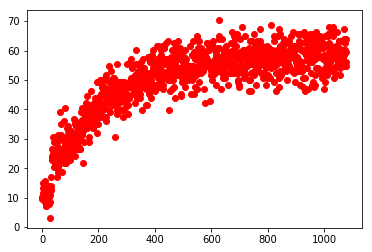

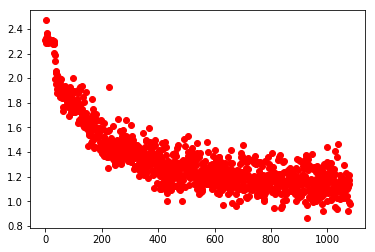

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

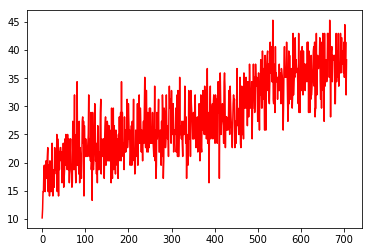

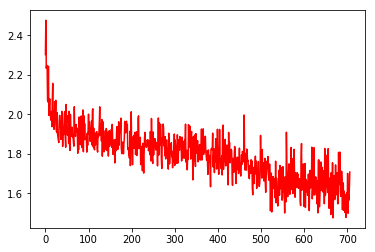

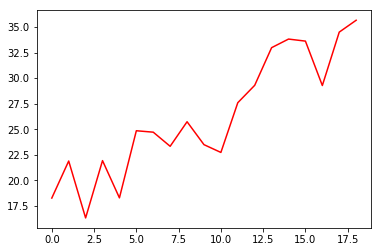

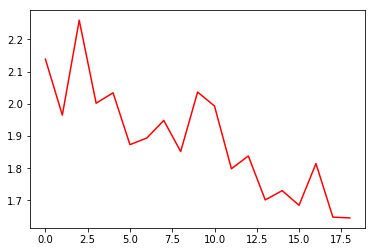

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()